# 🧠 MLSVA Experiment: Combined Pipeline

Unified notebook that merges the exploratory MLSVA workflow with the reproducible pipeline from `compare_shapley_methods.py`. Run the sections sequentially to generate datasets, train neural networks, and compare approximation strategies for Shapley values in routing problems.

## 1. Imports & Global Configuration

In [91]:

import math
import time
from dataclasses import dataclass
from itertools import combinations
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import keras_tuner as kt

warnings = __import__("warnings")
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import gurobipy as gp


## 2. Core Helper Functions

In [92]:

FEATURE_NAMES = [
    "N_customers",
    "total_instance_cost",
    "coordinate_std",
    "x_coord",
    "y_coord",
    "x_coord_depot",
    "y_coord_depot",
    "dist_to_depot",
    "norm_dist_to_depot",
    "dist_to_1_closest",
    "dist_to_2_closest",
    "dist_to_3_closest",
    "dist_to_gravity_center",
    "mean_distance_to_others",
]


def generate_random_tsp_instance(num_customers: int) -> np.ndarray:
    """Sample random 2D coordinates for a depot and a set of customers."""
    depot = np.array([50.0, 50.0])
    customers = np.random.rand(num_customers, 2) * 100.0
    return np.vstack([depot[None, :], customers])


def nn_cost(coalition: List[int], locations: np.ndarray) -> float:
    """Nearest-neighbor heuristic route length for a coalition."""
    if not coalition:
        return 0.0
    route = [0]
    unvisited = set(coalition)
    current = 0
    while unvisited:
        next_customer = min(
            unvisited,
            key=lambda idx: np.linalg.norm(locations[current] - locations[idx]),
        )
        route.append(next_customer)
        unvisited.remove(next_customer)
        current = next_customer
    route.append(0)
    return sum(
        np.linalg.norm(locations[route[i]] - locations[route[i + 1]])
        for i in range(len(route) - 1)
    )


def tsp_exact_cost(coalition: List[int], locations: np.ndarray) -> float:
    """Solve coalition TSP exactly via Gurobi."""
    nodes = [0] + list(coalition)
    if len(nodes) <= 1:
        return 0.0

    model = gp.Model()
    model.Params.OutputFlag = 0
    model.Params.Threads = 1

    distances = {
        (i, j): float(np.linalg.norm(locations[i] - locations[j]))
        for i in nodes
        for j in nodes
        if i != j
    }

    x = model.addVars(distances.keys(), vtype=gp.GRB.BINARY, name="x")
    model.setObjective(gp.quicksum(distances[i, j] * x[i, j] for (i, j) in distances), gp.GRB.MINIMIZE)

    for j in nodes:
        model.addConstr(gp.quicksum(x[i, j] for i in nodes if i != j) == 1)
        model.addConstr(gp.quicksum(x[j, k] for k in nodes if k != j) == 1)

    u = model.addVars(nodes, vtype=gp.GRB.CONTINUOUS, lb=0, ub=len(nodes) - 1, name="u")
    model.addConstr(u[0] == 0)
    for i in nodes:
        for j in nodes:
            if i == j or i == 0 or j == 0:
                continue
            model.addConstr(u[i] - u[j] + (len(nodes) - 1) * x[i, j] <= len(nodes) - 2)

    model.optimize()
    if model.Status != gp.GRB.OPTIMAL:
        raise RuntimeError("Gurobi failed to solve the TSP instance.")
    return float(model.ObjVal)


def feature_extractor(locations: np.ndarray, customer_id: int) -> np.ndarray:
    """Compute the 14 MLSVA features for one customer."""
    depot = locations[0]
    customers = list(range(1, locations.shape[0]))
    customer_loc = locations[customer_id]
    customer_locations = locations[customers]

    dist_to_depot = np.linalg.norm(customer_loc - depot)
    max_dist = np.max([np.linalg.norm(locations[idx] - depot) for idx in customers])
    norm_dist_to_depot = dist_to_depot / max_dist if max_dist > 0 else 0.0

    pairwise_dists = sorted(
        np.linalg.norm(customer_loc - locations[idx])
        for idx in customers
        if idx != customer_id
    )
    if pairwise_dists:
        d1 = pairwise_dists[0]
        d2 = pairwise_dists[1] if len(pairwise_dists) >= 2 else d1
        d3 = pairwise_dists[2] if len(pairwise_dists) >= 3 else d2
        mean_dist = float(np.mean(pairwise_dists))
    else:
        d1 = d2 = d3 = mean_dist = 0.0

    center_of_gravity = np.mean(customer_locations, axis=0)
    dist_cog = np.linalg.norm(customer_loc - center_of_gravity)
    total_cost = nn_cost(customers, locations)
    coord_std = float(np.std(customer_locations))

    return np.array([
        len(customers),
        total_cost,
        coord_std,
        customer_loc[0],
        customer_loc[1],
        depot[0],
        depot[1],
        dist_to_depot,
        norm_dist_to_depot,
        d1,
        d2,
        d3,
        dist_cog,
        mean_dist,
    ])


## 3. Shapley Value Estimators

In [93]:

def exact_shapley_value(
    locations: np.ndarray, customers: List[int], cost_func
) -> Dict[int, float]:
    """Exact definition (practical for small customer counts)."""
    phi: Dict[int, float] = {}
    n = len(customers)
    for player in customers:
        others = [c for c in customers if c != player]
        contributions, weights = [], []
        for k in range(n):
            for coalition in combinations(others, k):
                v_s = cost_func(list(coalition), locations)
                v_s_union = cost_func(list(coalition) + [player], locations)
                contributions.append(v_s_union - v_s)
                weights.append(
                    math.factorial(len(coalition))
                    * math.factorial(n - len(coalition) - 1)
                    / math.factorial(n)
                )
        phi[player] = float(np.dot(contributions, weights))
    return phi


def monte_carlo_shapley(
    locations: np.ndarray,
    customers: List[int],
    cost_func,
    num_samples: int,
) -> Dict[int, float]:
    """Standard Monte Carlo approximation."""
    phi: Dict[int, float] = {}
    n = len(customers)
    for player in customers:
        others = [c for c in customers if c != player]
        marginals = []
        for _ in range(num_samples):
            k = np.random.randint(0, n)
            coalition = (
                np.random.choice(others, size=k, replace=False).tolist()
                if k > 0
                else []
            )
            v_s = cost_func(coalition, locations)
            v_s_union = cost_func(coalition + [player], locations)
            marginals.append(v_s_union - v_s)
        phi[player] = float(np.mean(marginals))
    return phi


def heuristic_mc_shapley(
    locations: np.ndarray,
    customers: List[int],
    num_samples: int,
    lambda_max: int = 4,
    tau_factor: int = 4,
) -> Dict[int, float]:
    """Heuristic MC sampler following H2 configuration (lambda=4, tau=4|N|)."""
    phi: Dict[int, float] = {}
    n = len(customers)
    tau = tau_factor * n
    for player in customers:
        others = [c for c in customers if c != player]
        marginals: List[float] = []
        if not others:
            phi[player] = 0.0
            continue
        for _ in range(num_samples):
            coalition = set()
            for _ in range(tau):
                max_pick = min(lambda_max, len(others))
                k = np.random.randint(0, max_pick + 1)
                if k == 0:
                    continue
                selected = np.random.choice(others, size=k, replace=False)
                for sel in selected:
                    if sel in coalition:
                        coalition.remove(sel)
                    else:
                        coalition.add(sel)
            coalition_list = list(coalition)
            v_s = nn_cost(coalition_list, locations)
            v_s_union = nn_cost(coalition_list + [player], locations)
            marginals.append(v_s_union - v_s)
        phi[player] = float(np.mean(marginals)) if marginals else 0.0
    return phi


@dataclass
class MethodSpec:
    name: str
    kind: str  # "exact", "mc", or "hmc"
    num_samples: int | None = None


def run_method(
    locations: np.ndarray, customers: List[int], spec: MethodSpec
) -> Tuple[Dict[int, float], float]:
    start = time.perf_counter()
    if spec.kind == "exact":
        values = exact_shapley_value(locations, customers, nn_cost)
    elif spec.kind == "mc":
        values = monte_carlo_shapley(locations, customers, nn_cost, spec.num_samples)
    elif spec.kind == "hmc":
        values = heuristic_mc_shapley(locations, customers, spec.num_samples)
    else:
        raise ValueError(f"Unknown method kind: {spec.kind}")
    runtime = time.perf_counter() - start
    return values, runtime


## 4. Dataset Builders

In [94]:

def generate_dataset_variant(
    num_instances: int,
    num_customers: int,
    label_method: str = "Exact",
    num_samples: int = 500,
):
    """Reproduce the exploratory dataset builder from the lab notebook."""
    print(
        f"⚙️ Generating {label_method} dataset "
        f"({num_instances} instances, {num_customers} customers each)..."
    )
    all_X, all_y = [], []
    for _ in tqdm(range(num_instances)):
        locations = generate_random_tsp_instance(num_customers)
        customers = list(range(1, num_customers + 1))
        if label_method == "Exact":
            phi_dict = exact_shapley_value(locations, customers, nn_cost)
        elif label_method == "HMC":
            phi_dict = heuristic_mc_shapley(locations, customers, num_samples)
        else:
            phi_dict = monte_carlo_shapley(
                locations, customers, nn_cost, num_samples
            )
        for c in customers:
            all_X.append(feature_extractor(locations, c))
            all_y.append(phi_dict[c])
    X = np.vstack(all_X)
    y = np.array(all_y)
    print(f"✅ Finished {label_method} dataset: {X.shape[0]} samples.")
    return X, y


def generate_dataset_with_methods(
    num_instances: int,
    num_customers: int,
    target_spec: MethodSpec,
    comparison_specs: List[MethodSpec],
):
    """Pipeline builder used by the scripted experiment."""
    all_features, target_values = [], []
    method_predictions = {spec.name: [] for spec in comparison_specs}
    runtime_tracker = {spec.name: 0.0 for spec in [target_spec] + comparison_specs}

    for _ in range(num_instances):
        locations = generate_random_tsp_instance(num_customers)
        customers = list(range(1, num_customers + 1))

        target_phis, target_time = run_method(locations, customers, target_spec)
        runtime_tracker[target_spec.name] += target_time

        comparison_phis = {}
        for spec in comparison_specs:
            phis, elapsed = run_method(locations, customers, spec)
            runtime_tracker[spec.name] += elapsed
            comparison_phis[spec.name] = phis

        for customer in customers:
            features = feature_extractor(locations, customer)
            all_features.append(features)
            target_values.append(target_phis[customer])
            for method_name, phi_dict in comparison_phis.items():
                method_predictions[method_name].append(phi_dict[customer])

    features_array = np.vstack(all_features)
    targets_array = np.array(target_values)
    predictions_array = {k: np.array(v) for k, v in method_predictions.items()}
    return features_array, targets_array, predictions_array, runtime_tracker


In [95]:
def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_pred - y_true) / (y_true + 1e-9))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE (%)": mape}



def build_training_dataset(
    num_instances: int,
    num_customers: int,
    primary_spec: MethodSpec,
    auxiliary_specs: List[MethodSpec],
):
    print(
        f"\n--- Building training corpus ({primary_spec.name} + "
        f"{[spec.name for spec in auxiliary_specs]}) ---"
    )
    features, primary_labels, comparison_preds, _ = generate_dataset_with_methods(
        num_instances,
        num_customers,
        primary_spec,
        auxiliary_specs,
    )
    X_blocks = [features]
    y_blocks = [primary_labels]
    for spec in auxiliary_specs:
        X_blocks.append(features)
        y_blocks.append(comparison_preds[spec.name])
    X = np.vstack(X_blocks)
    y = np.concatenate(y_blocks)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    print(f"Training dataset size: {len(X):,} samples")
    return X[indices], y[indices]


## 5. Neural Network Trainers

In [96]:
def build_neural_network(input_dim: int) -> keras.Model:
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(256, activation="tanh"),
            layers.Dropout(0.2),
            layers.Dense(512, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=0.0015, weight_decay=1e-5),
        loss="mse",
        metrics=["mae"],
    )
    return model


def train_and_evaluate_nn(
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    label_name: str,
):
    print(f"\n🚀 Training Neural Network on {label_name} Data")
    model = build_neural_network(X_train_scaled.shape[1])
    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss", patience=25, restore_best_weights=True
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5
    )
    model.fit(
        X_train_scaled,
        y_train,
        validation_split=0.2,
        epochs=250,
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping, reduce_lr],
    )
    y_pred = model.predict(X_test_scaled, verbose=0).flatten()
    mape = np.mean(np.abs((y_pred - y_test) / (y_test + 1e-9))) * 100
    print(f"✅ {label_name}: MAPE = {mape:.2f}%")
    return mape


def train_nn_with_tuner(X: np.ndarray, y: np.ndarray, project_name: str = "tsp_shapley"):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    def build_model_with_hps(hp: kt.HyperParameters) -> keras.Model:
        model = keras.Sequential()
        model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
        units_1 = hp.Int("units_1", 128, 512, step=64)
        units_2 = hp.Int("units_2", 128, 512, step=64)
        units_3 = hp.Int("units_3", 64, 256, step=32)
        act_1 = hp.Choice("act_1", ["relu", "tanh"])
        act_2 = hp.Choice("act_2", ["relu", "tanh"])
        dropout_1 = hp.Float("dropout_1", 0.1, 0.4, step=0.1)
        dropout_2 = hp.Float("dropout_2", 0.1, 0.4, step=0.1)
        lr = hp.Float("lr", 1e-4, 5e-3, sampling="log")

        model.add(layers.Dense(units_1, activation=act_1, name="hidden_1"))
        model.add(layers.Dropout(dropout_1))
        model.add(layers.Dense(units_2, activation=act_2, name="hidden_2"))
        model.add(layers.Dropout(dropout_2))
        model.add(layers.Dense(units_3, activation="relu", name="hidden_3"))
        model.add(layers.Dense(1, name="output"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="mse",
            metrics=["mae"],
        )
        return model

    tuner = kt.BayesianOptimization(
        build_model_with_hps,
        objective="val_loss",
        max_trials=15,
        directory="mlsva_tuner",
        project_name=project_name,
        overwrite=True,
    )

    tuner.search(
        X_train_scaled,
        y_train,
        epochs=50,
        validation_data=(X_val_scaled, y_val),
        callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0,
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    model = tuner.hypermodel.build(best_hp)

    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss", patience=20, restore_best_weights=True, verbose=0
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5, verbose=0
    )

    start = time.perf_counter()
    model.fit(
        X_train_scaled,
        y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=0,
    )
    train_time = time.perf_counter() - start

    val_pred = model.predict(X_val_scaled, verbose=0).flatten()
    val_metrics = evaluate_predictions(y_val, val_pred)
    return model, scaler, train_time, val_metrics


## 6. Baseline Experiment (Exact vs. MC+H)

In [97]:
from pathlib import Path

NUM_TSP_INSTANCES = 5000
TSP_NUM_CUSTOMERS = 7
TSP_DATA_TAG = "tsp7_exact_gurobi"
cache_dir = Path("data_cache")
cache_dir.mkdir(exist_ok=True)

output_path = cache_dir / f"exact_dataset_{TSP_DATA_TAG}.csv"
baseline_datasets = {}

if output_path.exists():
    print(f"Loading exact dataset from {output_path}")
    df = pd.read_csv(output_path)
else:
    print(f"Generating {NUM_TSP_INSTANCES} exact TSP instances (n={TSP_NUM_CUSTOMERS}) with Gurobi...")
    records = []
    for _ in tqdm(range(NUM_TSP_INSTANCES)):
        locations = generate_random_tsp_instance(TSP_NUM_CUSTOMERS)
        customers = list(range(1, TSP_NUM_CUSTOMERS + 1))
        phi_dict = exact_shapley_value(locations, customers, tsp_exact_cost)
        total_cost = tsp_exact_cost(customers, locations)
        for customer in customers:
            features = feature_extractor(locations, customer)
            features[1] = total_cost
            records.append(np.concatenate([features, [phi_dict[customer]]]))
    records = np.array(records)
    df = pd.DataFrame(records, columns=FEATURE_NAMES + ["shapley_value"])
    df.to_csv(output_path, index=False)
    print(f"Saved dataset to {output_path}")

baseline_datasets["Exact"] = df
print(f"Exact dataset size: {len(df):,} rows")


Generating 5000 exact TSP instances (n=7) with Gurobi...


  0%|          | 0/5000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2026-11-23


100%|██████████| 5000/5000 [1:55:18<00:00,  1.38s/it]  


Saved dataset to data_cache/exact_dataset_tsp7_exact_gurobi.csv
Exact dataset size: 35,000 rows


In [ ]:
HMC_DATA_TAG = "tsp7_mc_h2"
HMC_NUM_SAMPLES = 250
hmc_output_path = cache_dir / f"hmc_dataset_{HMC_DATA_TAG}.csv"

if hmc_output_path.exists():
    print(f"Loading MC+H dataset from {hmc_output_path}")
    hmc_df = pd.read_csv(hmc_output_path)
else:
    print(
        f"Generating {NUM_TSP_INSTANCES} MC+H TSP instances (n={TSP_NUM_CUSTOMERS}) with heuristic sampler..."
    )
    records = []
    for _ in tqdm(range(NUM_TSP_INSTANCES)):
        locations = generate_random_tsp_instance(TSP_NUM_CUSTOMERS)
        customers = list(range(1, TSP_NUM_CUSTOMERS + 1))
        phi_dict = heuristic_mc_shapley(
            locations, customers, num_samples=HMC_NUM_SAMPLES, lambda_max=4, tau_factor=4
        )
        total_cost = nn_cost(customers, locations)
        for customer in customers:
            features = feature_extractor(locations, customer)
            features[1] = total_cost
            records.append(np.concatenate([features, [phi_dict[customer]]]))
    records = np.array(records)
    hmc_df = pd.DataFrame(records, columns=FEATURE_NAMES + ["shapley_value"])
    hmc_df.to_csv(hmc_output_path, index=False)
    print(f"Saved dataset to {hmc_output_path}")

baseline_datasets["HMC"] = hmc_df
print(f"MC+H dataset size: {len(hmc_df):,} rows")


Generating 5000 MC+H TSP instances (n=7) with heuristic sampler...


 11%|█▏        | 563/5000 [03:29<27:37,  2.68it/s]

## 7. Methods Overview

1. **Neural Network (NN)** – Deep feed-forward model capturing nonlinear feature interactions via backpropagation.
2. **Random Forest (RF)** – Ensemble of bootstrap decision trees averaged to reduce variance.
3. **XGBoost** – Gradient-boosted tree sequence that iteratively corrects residual errors with regularization.
4. **Polynomial Regression (PR)** – Linear regression on polynomial feature expansions (e.g., quadratic terms) to model smooth nonlinear trends.
5. **Support Vector Regression (SVR)** – Kernel-based regressor fitting an "epsilon"-tube to data for robust predictions.
6. **K-Nearest Neighbors (KNN)** – Non-parametric regressor averaging targets of the closest points in feature space.

## 8. Target & Feature Analysis

Using the Exact dataset for exploratory plots.
Shapley-value summary statistics by dataset:


,count,mean,std,min,25%,50%,75%,max
Exact,35000.0,36.304253,20.701328,0.111085,20.095369,33.041642,49.189814,122.928352
HMC,35000.0,34.632208,21.738989,-7.062893,17.935157,30.025506,47.321337,130.055030


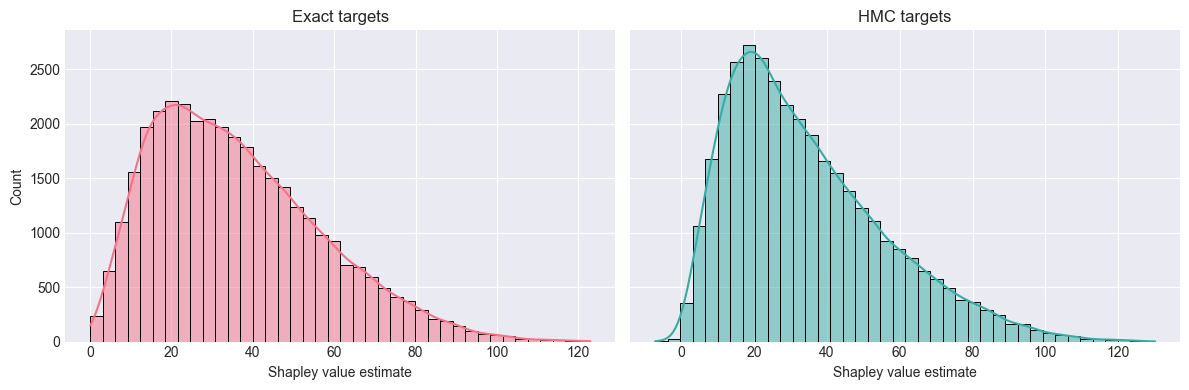

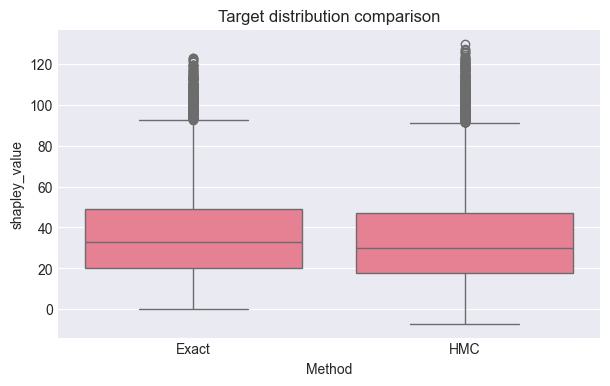

In [104]:
analysis_dataset_name = "Exact" if "Exact" in baseline_datasets else next(iter(baseline_datasets))
analysis_dataset = baseline_datasets[analysis_dataset_name]

print(f"Using the {analysis_dataset_name} dataset for exploratory plots.")

target_stats = pd.DataFrame(
    {name: df_variant["shapley_value"].describe() for name, df_variant in baseline_datasets.items()}
).T
print("Shapley-value summary statistics by dataset:")
display(target_stats)

num_methods = len(baseline_datasets)
fig, axes = plt.subplots(1, num_methods, figsize=(6 * num_methods, 4), sharey=True)
if num_methods == 1:
    axes = [axes]
palette = sns.color_palette("husl", num_methods)
for ax, (name, df_variant), color in zip(axes, baseline_datasets.items(), palette):
    sns.histplot(df_variant["shapley_value"], bins=40, kde=True, ax=ax, color=color)
    ax.set_title(f"{name} targets")
    ax.set_xlabel("Shapley value estimate")
plt.tight_layout()

melted_targets = []
for name, df_variant in baseline_datasets.items():
    temp = df_variant[["shapley_value"]].copy()
    temp["Method"] = name
    melted_targets.append(temp)
combined_targets = pd.concat(melted_targets, ignore_index=True)
plt.figure(figsize=(7, 4))
sns.boxplot(data=combined_targets, x="Method", y="shapley_value")
plt.title("Target distribution comparison")
plt.show()


Feature summary for Exact labels:


,count,mean,std,min,25%,50%,75%,max
N_customers,35000.0,7.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000
total_instance_cost,35000.0,254.129771,38.743903,94.791034,228.136683,254.960174,280.672590,386.536908
coordinate_std,35000.0,27.540526,3.701409,8.898808,25.202216,27.634701,30.110432,39.186372
x_coord,35000.0,50.077355,28.767767,0.000554,25.223520,50.144507,74.967804,99.997215
y_coord,35000.0,49.901209,28.890444,0.000843,24.895948,49.968743,74.942714,99.990098
x_coord_depot,35000.0,50.000000,0.000000,50.000000,50.000000,50.000000,50.000000,50.000000
y_coord_depot,35000.0,50.000000,0.000000,50.000000,50.000000,50.000000,50.000000,50.000000
dist_to_depot,35000.0,38.202395,14.240547,0.199699,28.128021,39.790456,48.801942,70.568024
norm_dist_to_depot,35000.0,0.684291,0.248233,0.004025,0.505071,0.716724,0.897869,1.000000
dist_to_1_closest,35000.0,22.702952,13.096146,0.035563,12.859062,20.677521,30.064522,93.859827


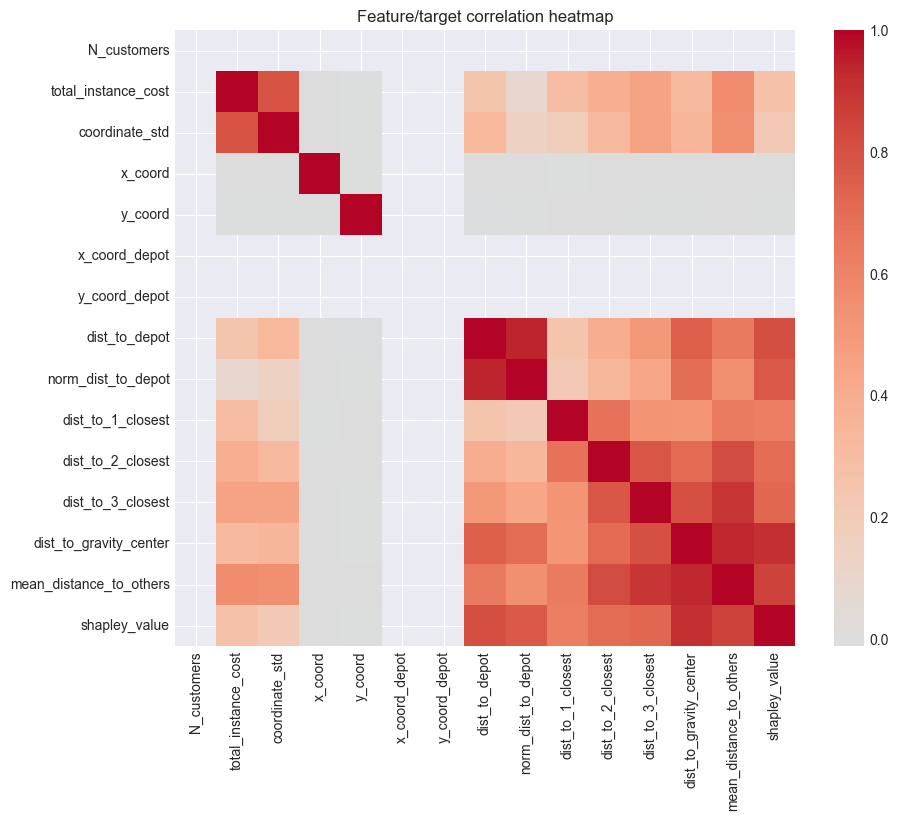

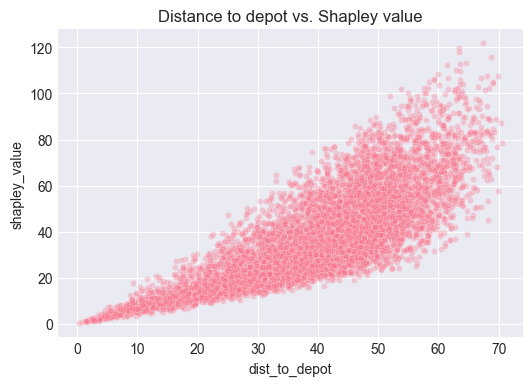

In [105]:

feature_summary = analysis_dataset[FEATURE_NAMES].describe().T
print(f"Feature summary for {analysis_dataset_name} labels:")
display(feature_summary)

corr_matrix = analysis_dataset[FEATURE_NAMES + ["shapley_value"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature/target correlation heatmap")
plt.show()

sample_plot = analysis_dataset.sample(n=min(8000, len(analysis_dataset)), random_state=RANDOM_SEED)
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=sample_plot,
    x="dist_to_depot",
    y="shapley_value",
    alpha=0.3,
    s=20,
)
plt.title("Distance to depot vs. Shapley value")
plt.show()


## 9. Neural Network Benchmark

In [ ]:

nn_results = {}
for name, df_variant in baseline_datasets.items():
    X = df_variant.drop("shapley_value", axis=1)
    y = df_variant["shapley_value"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    start = time.time()
    mape = train_and_evaluate_nn(X_train_scaled, X_test_scaled, y_train, y_test, name)
    nn_results[name] = {
        "MAPE": mape,
        "Runtime (min)": (time.time() - start) / 60,
    }

nn_results_df = pd.DataFrame(nn_results).T
nn_results_df



🚀 Training Neural Network on Exact Data


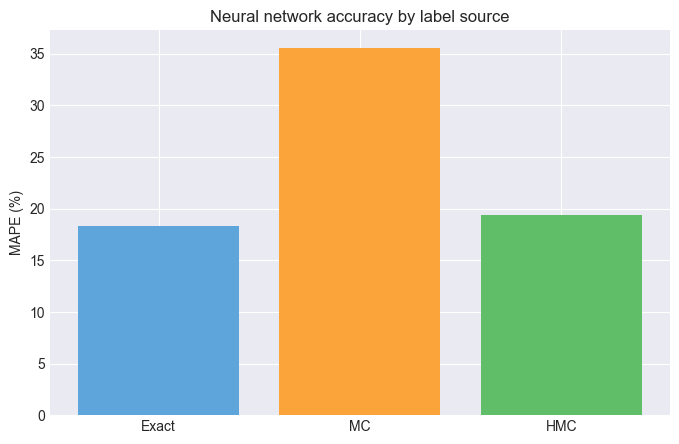

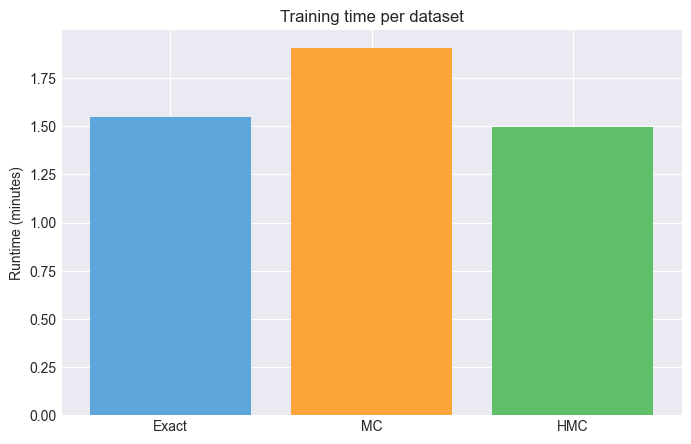


Final NN comparison table:


,MAPE,Runtime (min)
Exact,18.320542,1.547926
MC,35.505005,1.904427
HMC,19.371278,1.494838


In [47]:
palette = sns.color_palette("Set2", len(nn_results_df))
plt.figure(figsize=(8, 5))
plt.bar(nn_results_df.index, nn_results_df["MAPE"], color=palette)
plt.ylabel("MAPE (%)")
plt.title("Neural network accuracy by label source")
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(
    nn_results_df.index,
    nn_results_df["Runtime (min)"],
    color=palette,
)
plt.ylabel("Runtime (minutes)")
plt.title("Training time per dataset")
plt.show()

print("\nFinal NN comparison table:")
nn_results_df


In [50]:
history_features = analysis_dataset.drop("shapley_value", axis=1)
history_targets = analysis_dataset["shapley_value"]
X_train, X_test, y_train, y_test = train_test_split(
    history_features, history_targets, test_size=0.2, random_state=RANDOM_SEED
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = build_neural_network(X_train_scaled.shape[1])
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=25, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5
)

history_nn = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[early_stopping, reduce_lr],
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_nn.history["loss"], label="Train Loss", linewidth=2)
axes[0].plot(history_nn.history["val_loss"], label="Val Loss", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss (MSE)")
axes[0].set_title("Neural Network - Training History (Loss)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_nn.history["mae"], label="Train MAE", linewidth=2)
axes[1].plot(history_nn.history["val_mae"], label="Val MAE", linewidth=2)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")
axes[1].set_title("Neural Network - Training History (MAE)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

## 10. Classical Regression Benchmarks

In [48]:

model_registry = {
    "Linear Regression": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
    "Ridge Regression": Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))]),
    "Polynomial Regression": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("model", LinearRegression()),
        ]
    ),
    "Support Vector Regression": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", SVR(C=10.0, epsilon=0.1, kernel="rbf")),
        ]
    ),
    "K-Nearest Neighbors": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", KNeighborsRegressor(n_neighbors=15, weights="distance")),
        ]
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=350,
        max_depth=25,
        min_samples_leaf=2,
        bootstrap=True,
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        tree_method="hist",
    ),
}


def evaluate_classical_models(datasets):
    rows = []
    for label_name, df_variant in datasets.items():
        X = df_variant.drop("shapley_value", axis=1)
        y = df_variant["shapley_value"]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED
        )
        for model_name, estimator in model_registry.items():
            model = clone(estimator)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            metrics = evaluate_predictions(y_test, preds)
            metrics["R2"] = r2_score(y_test, preds)
            metrics["Method"] = label_name
            metrics["Model"] = model_name
            rows.append(metrics)
    return pd.DataFrame(rows)

classical_results_df = evaluate_classical_models(baseline_datasets)
classical_results_df


,MAE,RMSE,MAPE (%),R2,Method,Model
0,4.796380,6.254603,22.379826,0.904146,Exact,Linear Regression
1,4.796408,6.254560,22.379906,0.904147,Exact,Ridge Regression
2,3.812461,5.034458,19.434266,0.937896,Exact,Polynomial Regression
3,3.605224,4.896436,17.845026,0.941255,Exact,Support Vector Regression
4,4.324286,5.778852,20.376179,0.918173,Exact,K-Nearest Neighbors
5,3.935153,5.239679,19.259413,0.932730,Exact,Random Forest
6,3.702865,4.966678,18.322781,0.939557,Exact,XGBoost
7,4.950144,6.425458,40.658280,0.897804,MC,Linear Regression
8,4.950154,6.425474,40.660119,0.897803,MC,Ridge Regression
9,3.964680,5.208624,37.881606,0.932846,MC,Polynomial Regression


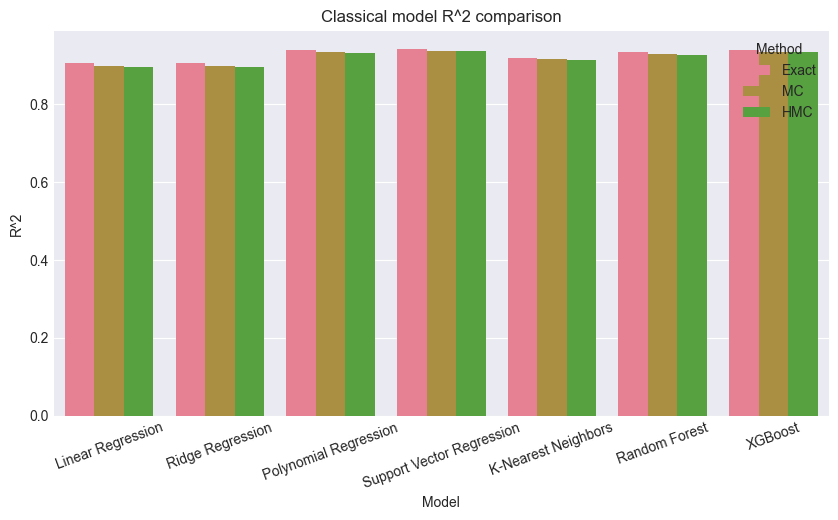

In [88]:

plt.figure(figsize=(10, 5))
sns.barplot(
    data=classical_results_df,
    x="Model",
    y="R2",
    hue="Method",
)
plt.title("Classical model R^2 comparison")
plt.ylabel("R^2")
plt.xticks(rotation=20)
plt.show()


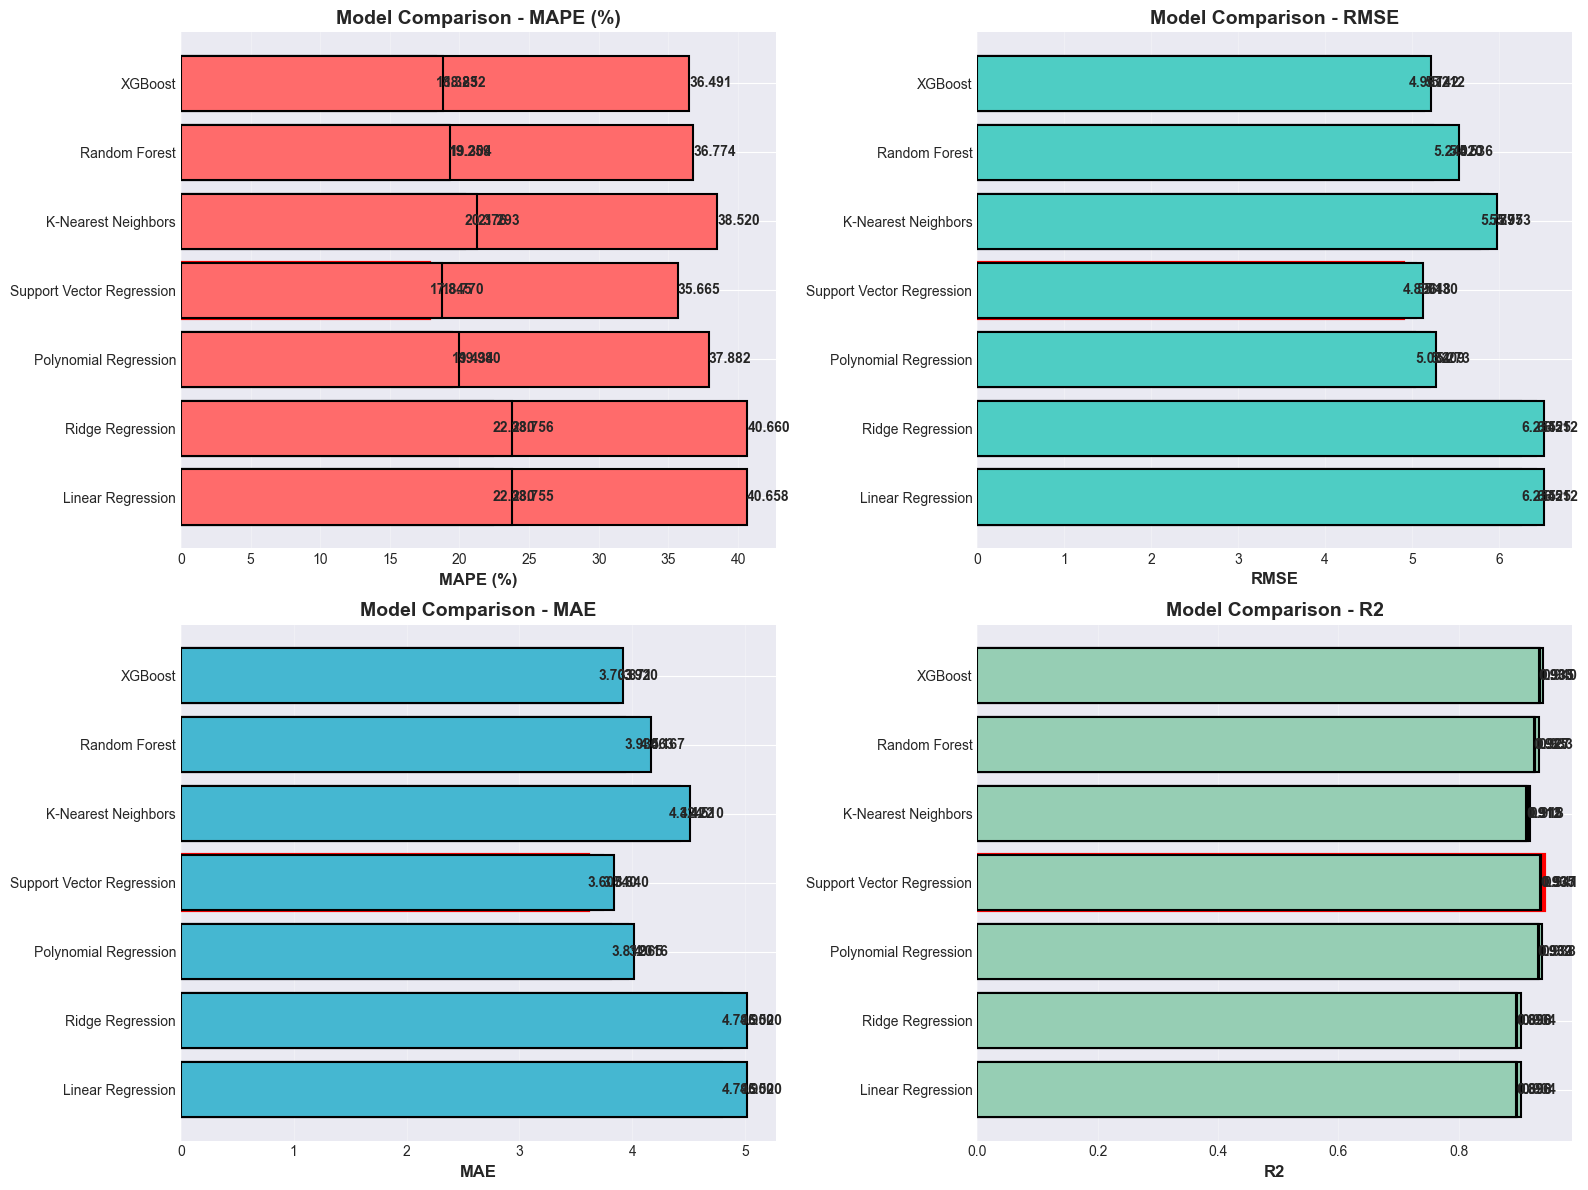

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ["MAPE (%)", "RMSE", "MAE", "R2"]
colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4"]

for ax, metric, color in zip(axes.flat, metrics, colors):
    values = classical_results_df[metric].values
    models = classical_results_df["Model"].values

    bars = ax.barh(models, values, color=color, edgecolor="black", linewidth=1.5)

    best_idx = values.argmax() if metric == "R2" else values.argmin()
    bars[best_idx].set_color("#FFD93D")
    bars[best_idx].set_edgecolor("red")
    bars[best_idx].set_linewidth(3)

    ax.set_xlabel(metric, fontsize=12, fontweight="bold")
    ax.set_title(f"Model Comparison - {metric}", fontsize=14, fontweight="bold")
    ax.grid(axis="x", alpha=0.3)

    for bar, val in zip(bars, values):
        ax.text(val, bar.get_y() + bar.get_height() / 2,
                f"{val:.3f}", va="center", ha="left",
                fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()


In [53]:
nn_rows = []
for method, df_variant in baseline_datasets.items():
    X = df_variant.drop("shapley_value", axis=1)
    y = df_variant["shapley_value"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = build_neural_network(X_train_scaled.shape[1])
    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss", patience=25, restore_best_weights=True
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5
    )
    history_nn = model.fit(
        X_train_scaled,
        y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        verbose=0,
        callbacks=[early_stopping, reduce_lr],
    )
    y_pred = model.predict(X_test_scaled, verbose=0).flatten()

    metrics = evaluate_predictions(y_test, y_pred)
    metrics["R2"] = r2_score(y_test, y_pred)
    metrics["Method"] = method
    metrics["Model"] = "Neural Net"
    nn_rows.append(metrics)

nn_results_long = pd.DataFrame(nn_rows)


## 11. Tuned Neural Network via MLSVA Workflow

In [82]:
preferred_sources = ["Exact", "HMC"]
training_sources = [name for name in preferred_sources if name in baseline_datasets]
print(f"Tuning separate neural nets for: {training_sources}")

tuned_nn_models = {}
for source in training_sources:
    df = baseline_datasets[source]
    training_features = df.drop("shapley_value", axis=1).values
    training_labels = df["shapley_value"].values
    print(f"
--- Tuning NN on {source} dataset ({training_features.shape[0]:,} samples) ---")
    model, scaler, train_time, val_metrics = train_nn_with_tuner(
        training_features,
        training_labels,
        project_name=f"tsp_shapley_cached_{source.lower()}",
    )
    tuned_nn_models[source] = {
        "model": model,
        "scaler": scaler,
        "train_time": train_time,
        "val_metrics": val_metrics,
    }
    print(
        f"Validation MAPE ({source}): {val_metrics['MAPE (%)']:.2f}% | "
        f"MAE: {val_metrics['MAE']:.4f}"
    )


Tuning separate neural nets for: ['HMC']

--- Tuning NN on HMC dataset (40,000 samples) ---
Validation MAPE (HMC): 18.90% | MAE: 3.7935


In [83]:
tuned_nn_rows = []
for source, artifacts in tuned_nn_models.items():
    df_variant = baseline_datasets[source]
    X_scaled = artifacts["scaler"].transform(df_variant.drop("shapley_value", axis=1))
    y = df_variant["shapley_value"].values
    preds = artifacts["model"].predict(X_scaled, verbose=0).flatten()
    metrics = evaluate_predictions(y, preds)
    metrics["R2"] = r2_score(y, preds)
    metrics["Method"] = source
    metrics["Model"] = "Tuned Neural Net"
    tuned_nn_rows.append(metrics)

if tuned_nn_rows:
    tuned_nn_results = pd.DataFrame(tuned_nn_rows)
else:
    tuned_nn_results = pd.DataFrame(columns=["MAE", "RMSE", "MAPE (%)", "R2", "Method", "Model"])

all_results = pd.concat(
    [classical_results_df, nn_results_long, tuned_nn_results],
    ignore_index=True,
)
all_results


,MAE,RMSE,MAPE (%),R2,Method,Model
0,4.796380,6.254603,22.379826,0.904146,Exact,Linear Regression
1,4.796408,6.254560,22.379906,0.904147,Exact,Ridge Regression
2,3.812461,5.034458,19.434266,0.937896,Exact,Polynomial Regression
3,3.605224,4.896436,17.845026,0.941255,Exact,Support Vector Regression
4,4.324286,5.778852,20.376179,0.918173,Exact,K-Nearest Neighbors
5,3.935153,5.239679,19.259413,0.932730,Exact,Random Forest
6,3.702865,4.966678,18.322781,0.939557,Exact,XGBoost
7,4.950144,6.425458,40.658280,0.897804,MC,Linear Regression
8,4.950154,6.425474,40.660119,0.897803,MC,Ridge Regression
9,3.964680,5.208624,37.881606,0.932846,MC,Polynomial Regression


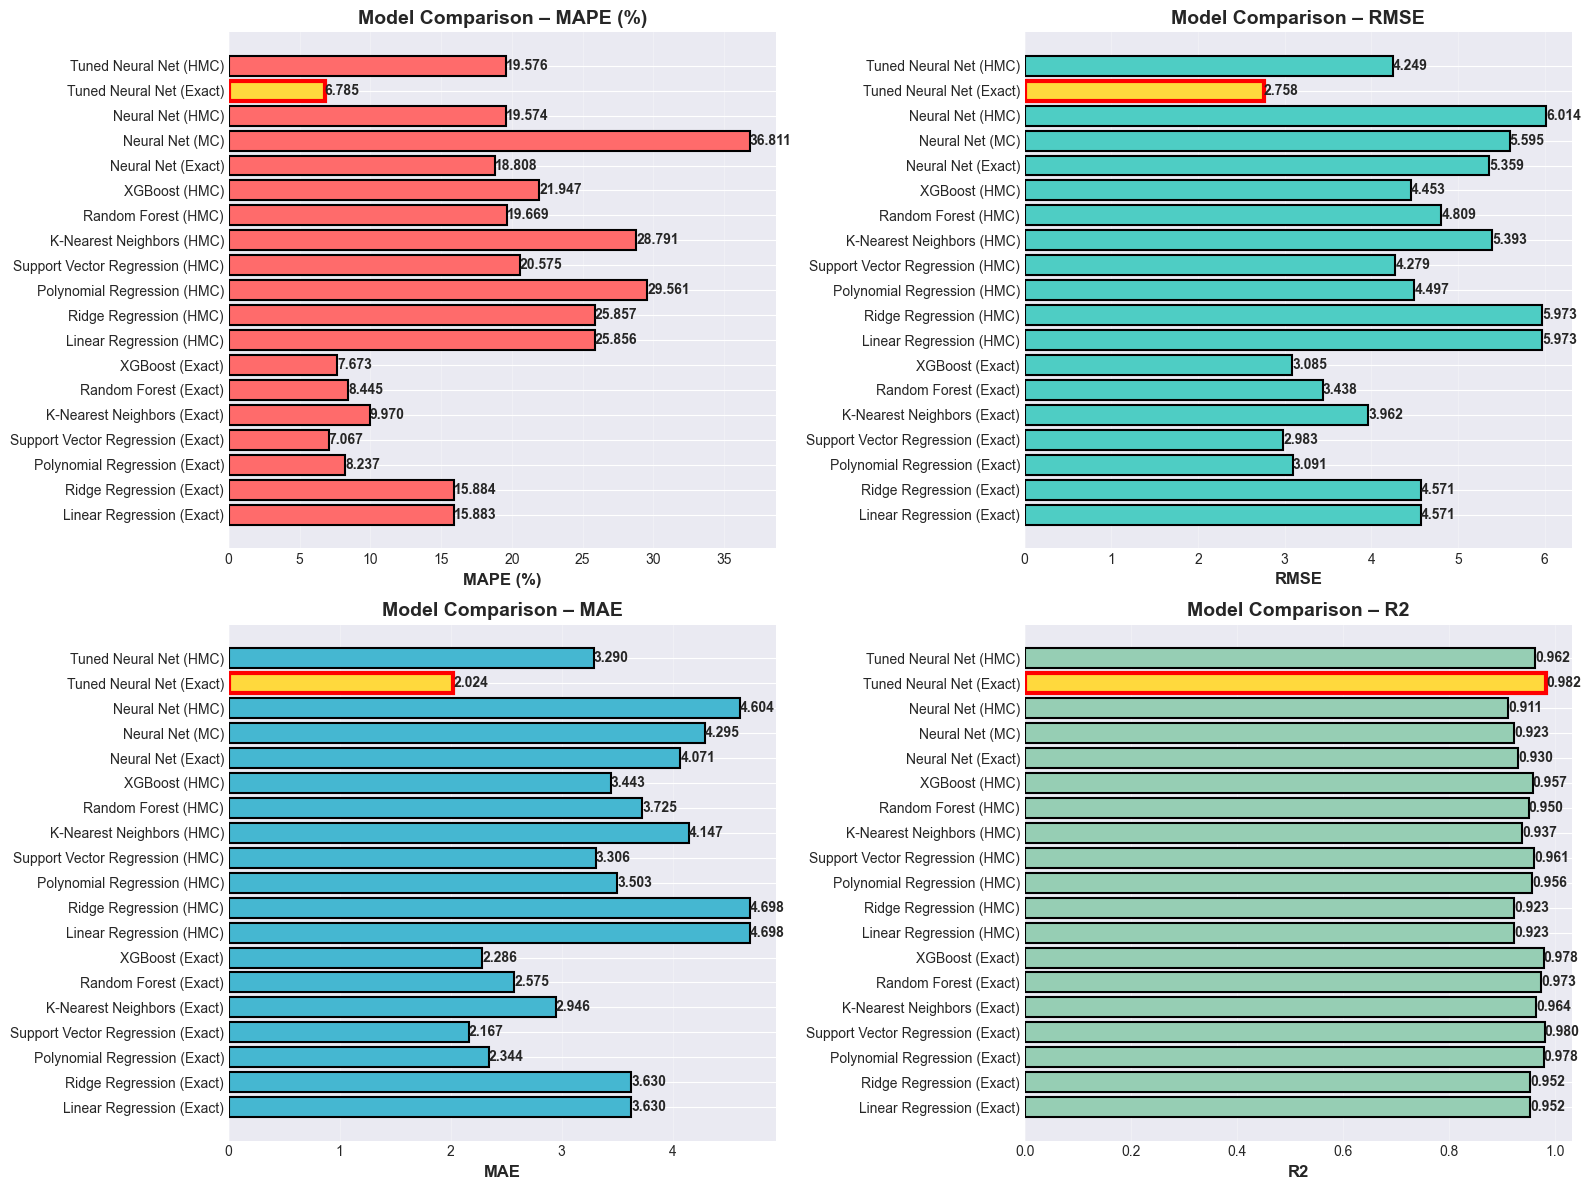

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ["MAPE (%)", "RMSE", "MAE", "R2"]
colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4"]

for ax, metric, color in zip(axes.flat, metrics, colors):
    values = all_results[metric].values
    labels = all_results["Model"] + " (" + all_results["Method"] + ")"
    bars = ax.barh(labels, values, color=color, edgecolor="black", linewidth=1.5)
    best_idx = values.argmax() if metric == "R2" else values.argmin()
    bars[best_idx].set_color("#FFD93D")
    bars[best_idx].set_edgecolor("red")
    bars[best_idx].set_linewidth(3)
    ax.set_xlabel(metric, fontsize=12, fontweight="bold")
    ax.set_title(f"Model Comparison – {metric}", fontsize=14, fontweight="bold")
    ax.grid(axis="x", alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(val, bar.get_y() + bar.get_height()/2, f"{val:.3f}",
                va="center", ha="left", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()


In [90]:
# removed HMC summary

FINAL SUMMARY - KEY FINDINGS (HMC only)

1. BEST PERFORMING MODEL
   Model: Support Vector Regression (HMC)
   MAPE: 18.7697%
   R²: 0.9353

2. MODEL RANKING (by MAPE)
   1. Support Vector Regression (HMC): 18.7697%
   2. XGBoost (HMC): 18.8521%
   3. Tuned Neural Net (HMC): 19.0180%
   4. Random Forest (HMC): 19.3045%
   5. Neural Net (HMC): 19.5743%
   6. Polynomial Regression (HMC): 19.9796%
   7. K-Nearest Neighbors (HMC): 21.2926%
   8. Linear Regression (HMC): 23.7549%
   9. Ridge Regression (HMC): 23.7561%

✓ Analysis Complete!
